In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.unicode_minus'] = False

## Hypothesis

-  Trip duration is primarily affected by the <font color=blue>pickup_latitute|longitude &amp; dropoff_latitute|longitude</font>. Duration would be a direct function of the trip distance, which is in turn dependent on pickup and dropoff coordinates.
-  Factors like <font color=blue>pickup_datetime</font> also have slight affect on duration. Like during rush hour traffic.
-  Factors like <font color=blue>passenger_count</font> have no affect on trip duration.

#### Read data from CSV

In [2]:
input_data = pd.read_csv('data/train.csv')

In [3]:
input_data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


### Visualizing given data

#### `trip_duration` histogram
To study the distribution of trip duration within the dataset.

In [4]:
#logarithmic normalization of trip duration.
log_duration = np.log(input_data['trip_duration'].values+1)

logarithm of trip duration


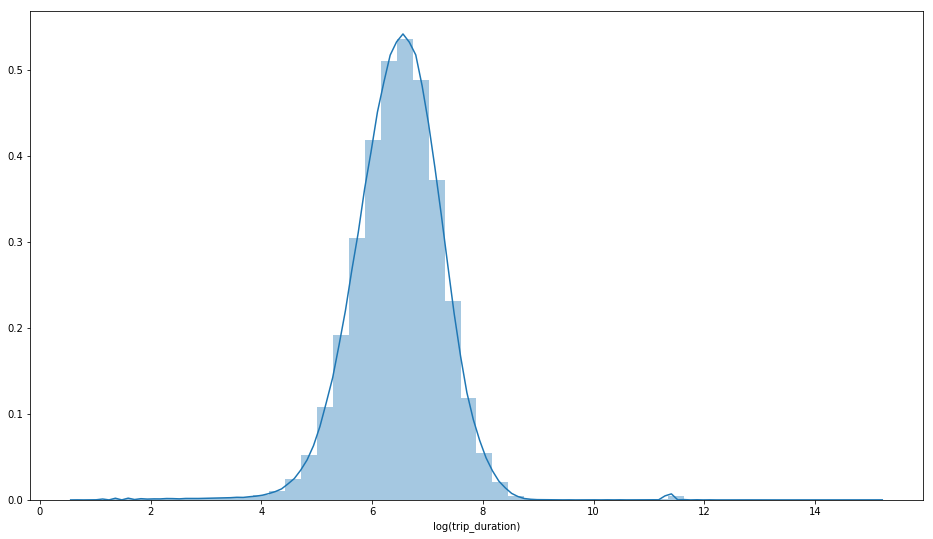

In [5]:
print('logarithm of trip duration')
sns.distplot(log_duration, axlabel='log(trip_duration)')

The above vizualization reveals that maximium number of trips taken were of duration e^7 seconds that is **18 minutes**.

Some trips have <font color=red>abnormally large durations</font> such as **45 hours**. These are most likely outstation trips. Such as to `LA` or `Alaska` and return.

#### Plot latitutes & longitudes for pickup and dropoff
Done to estimate trends and hotspots of locations.

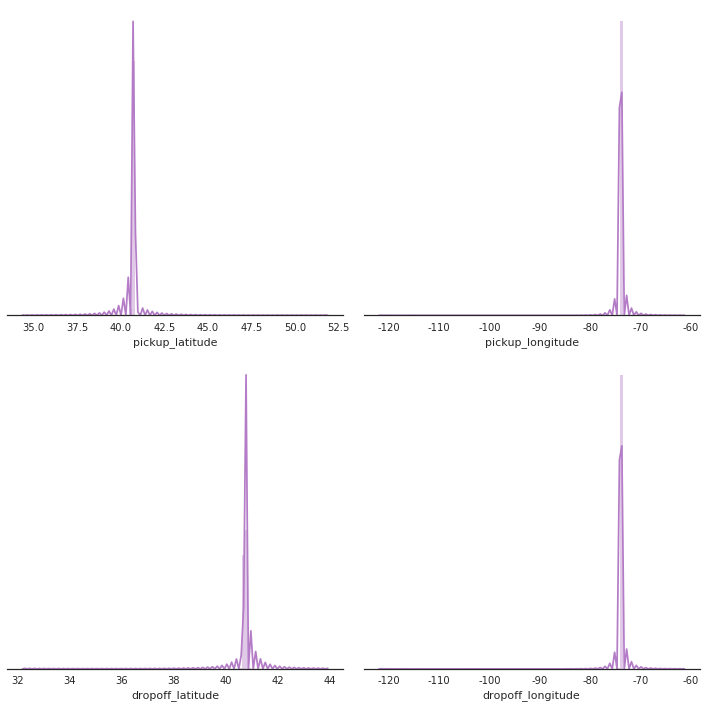

In [6]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(input_data['pickup_latitude'].values, 
             axlabel = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(input_data['pickup_longitude'].values, 
             axlabel = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(input_data['dropoff_latitude'].values, 
             axlabel = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(input_data['dropoff_longitude'].values, 
             axlabel = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Above figures show-
-  Pick and drop latitude are centered around 40 to 41. 
-  Longitude are situated around -74 to -73. 

#### Heatmap of trips taken from a location

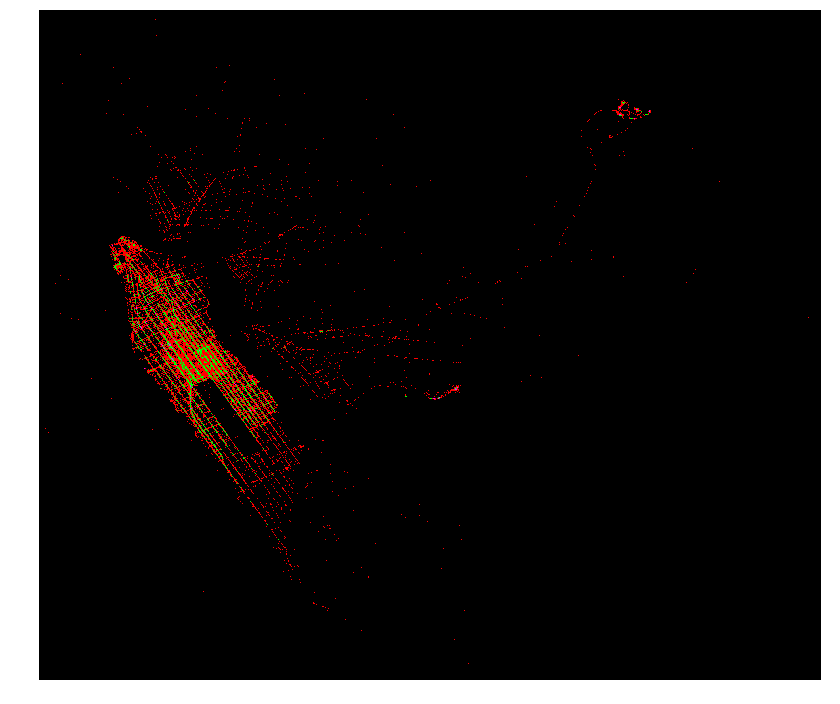

In [7]:
# create a copy of data frame to generate an image with
im_data = input_data.copy()
# clip latitudes and longitutes to modal locations found above
im_data = im_data.loc[(im_data.pickup_latitude > 40.6) & (im_data.pickup_latitude < 40.9)]
im_data = im_data.loc[(im_data.dropoff_latitude > 40.6) & (im_data.dropoff_latitude < 40.9)]
im_data = im_data.loc[(im_data.dropoff_longitude > -74.05) & (im_data.dropoff_longitude < -73.7)]
im_data = im_data.loc[(im_data.pickup_longitude > -74.05) & (im_data.pickup_longitude < -73.7)]
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
im_data['pick_lat_new'] = list(map(int, (im_data['pickup_latitude'] - (40.6000))*10000))
im_data['drop_lat_new'] = list(map(int, (im_data['dropoff_latitude'] - (40.6000))*10000))
im_data['pick_lon_new'] = list(map(int, (im_data['pickup_longitude'] - (-74.050))*10000))
im_data['drop_lon_new'] = list(map(int,(im_data['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(im_data.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 
del summary_plot, im_data

**Legend:**
-  Red 1-10.
-  Green 10-50.
-  Yellow 50+.

The Yellow region on the map is **Manhatten** indicating most trips orignate from there.

## XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

XGBoost will be used to model the relation between <font color=green>trip_duration</font> and other independent variables as indicated by our hypothesis.

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [9]:
input_data['pickup_datetime'] = pd.to_datetime(input_data['pickup_datetime'])
input_data['pickup_min_of_day'] = input_data['pickup_datetime'].dt.hour*60 + input_data['pickup_datetime'].dt.minute
input_data['log_trip_duration'] = np.log(input_data['trip_duration'].values + 1)
X = input_data[['pickup_latitude', 'pickup_longitude', 'passenger_count',     
                'dropoff_latitude', 'dropoff_longitude', 'pickup_min_of_day']]
Y = input_data['log_trip_duration']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [11]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1., 'nthread': 4, 
            'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 100, watchlist,
                  early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:3.06787	valid-rmse:3.06853
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.63642	valid-rmse:1.63766
[2]	train-rmse:0.980541	valid-rmse:0.982654
[3]	train-rmse:0.722194	valid-rmse:0.725237
[4]	train-rmse:0.618991	valid-rmse:0.622494
[5]	train-rmse:0.588512	valid-rmse:0.59241
[6]	train-rmse:0.57798	valid-rmse:0.582087
[7]	train-rmse:0.564314	valid-rmse:0.568735
[8]	train-rmse:0.553189	valid-rmse:0.557504
[9]	train-rmse:0.549384	valid-rmse:0.553683
[10]	train-rmse:0.54839	valid-rmse:0.552583
[11]	train-rmse:0.541006	valid-rmse:0.545301
[12]	train-rmse:0.521855	valid-rmse:0.526374
[13]	train-rmse:0.519208	valid-rmse:0.523785
[14]	train-rmse:0.510692	valid-rmse:0.515258
[15]	train-rmse:0.509704	valid-rmse:0.51429
[16]	train-rmse:0.505496	valid-rmse:0.5102
[17]	train-rmse:0.503911	valid-rmse:0.508604
[18]	train-rmse:0.498797	valid-rmse:0.503446
[19]	train-rmse:0.497

#### Examining Results

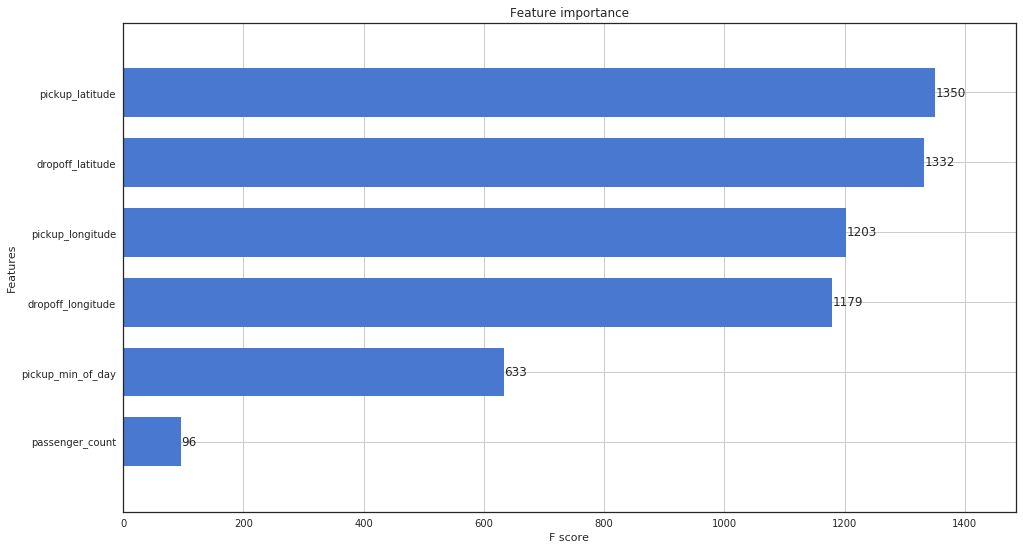

In [12]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

The above learnt representation of souce data concurs with the original Hypthesis.
- Spatial coordinates are favored the most.
- Time of the day has some significance.
- Weight of passenger count is negligible.

In [13]:
# predicted trip duration
pred = model.predict(dvalid)
pred = np.exp(pred) - 1

In [14]:
# actual trip duration
known_val = np.exp(y_test) - 1
known_val = known_val.values

In [16]:
# calcuate the accuracy metric
error = np.abs(pred-known_val)/known_val
error = np.mean(error)
accuracy = 1-error
print('accuracy: {:10.4f}%'.format(accuracy*100))

accuracy:    61.4737%


The model has an accuracy of <font color=red>61.4739%</font>

It can be imporved using the following techniques- 
1. Allowing the model to train for longer durations.
2. Grouping soucre data using methods such as KMeans clustering, and PCA
3. Neural networks can model multivariate functions with higher accuracy.